In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

# Input space transformation (dimensionality reduction)
from sklearn.decomposition import PCA
from sklearn import random_projection
from sklearn import cluster
from sklearn.random_projection import johnson_lindenstrauss_min_dim

import utils

from clustering_adv_sample_detection import ClusterAdversarialClassifier as Classifier

## Testing Cluster Adversarial Classifier

### Load Data

In [2]:
# MNIST
X_train, y_train, X_test, y_test = utils.load_mnist()

# Perfomance on MNIST with PCA transform, FC NN, and eps=3e-2: 
# Wall time: 1min 33s
# Cluster Classifier Accuracy on clean data: 97.930
# Cluster Classifier Accuracy on adversarial data: 92.460
# Percentage of input data flagged as suspicious by detector: 45.670

# Fashion MNIST
#X_train, y_train, X_test, y_test = utils.load_fashion_mnist()

# Perfomance on Fashion MNIST with PCA transform, FC NN, and eps=3e-2: 
# Wall time: 2min
# Cluster Classifier Accuracy on clean data: 87.760
# Cluster Classifier Accuracy on adversarial data: 79.280
# Percentage of input data flagged as suspicious by detector: 46.340

# CIFAR-10
#X_train, y_train, X_test, y_test = utils.load_cifar10()

# Perfomance on CIFAR-10 with PCA transform, FC NN, and eps=3e-2:  
# Wall time: 8min 28s
# Cluster Classifier Accuracy on clean data: 51.990
# Cluster Classifier Accuracy on adversarial data: 43.500
# Percentage of input data flagged as suspicious by detector: 55.520

### Create Black Box Attack (training data for baseline model)

c:\users\jason\appdata\local\programs\python\python39\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 0 - Training loss: 0.25219657834595577
Epoch 1 - Training loss: 0.11318132198754254
Epoch 2 - Training loss: 0.10549541980445497
Epoch 3 - Training loss: 0.08047573627273683
Epoch 4 - Training loss: 0.06091399803970612

Training Time (in minutes) = 2.7106473445892334
Predicted Digit = 4
Number Of Images Tested = 10000

Model Accuracy = 0.9842


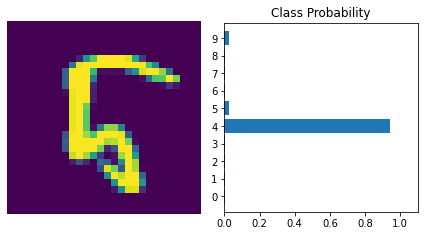

In [3]:
# Train model for black box attack
from model import My_VGG as Model

attacked_model = Model(in_channels=1, in_size=28, num_classes=10)
attacked_model = utils.train_model(attacked_model, X_train, X_test, y_train, y_test, epochs=5)

# Create training and test data for baseline (adversarially trained) model

baseline_training_eps = 2e-2

train_dataloader = utils.create_dataloader(X_train, y_train)
test_dataloader = utils.create_dataloader(X_test, y_test)
adv_train_data = utils.add_adversarial_noise(attacked_model, train_dataloader, eps=baseline_training_eps)
adv_test_data = utils.add_adversarial_noise(attacked_model, test_dataloader, eps=baseline_training_eps)

baseline_train_data = np.concatenate((X_train, adv_train_data), axis=0)
baseline_train_labels = np.concatenate((y_train, y_train), axis=0)

test_data = np.concatenate((X_test, adv_test_data), axis=0)
test_labels = np.concatenate((y_test, y_test), axis=0)

## Train Baseline Model (adversarial training)

In [4]:
baseline_model = Model(in_channels=1, in_size=28, num_classes=10)

Epoch 0 - Training loss: 0.17587602903620475
Epoch 1 - Training loss: 0.08932574900484062
Epoch 2 - Training loss: 0.046647060580611285
Epoch 3 - Training loss: 0.03295362294461539
Epoch 4 - Training loss: 0.03146788619817849

Training Time (in minutes) = 4.839011092980702
Predicted Digit = 9
Number Of Images Tested = 20000

Model Accuracy = 0.99145


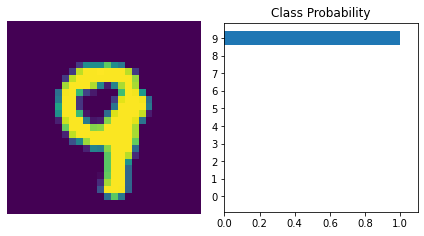

In [5]:
baseline_model = utils.train_model(baseline_model, baseline_train_data, test_data, baseline_train_labels, test_labels, epochs=5)

## Train Clustering Classifier

### Train Base Neural Network For Clustering Detector/Classifier

In [6]:
model = Model(in_channels=1, in_size=28, num_classes=10)

Epoch 0 - Training loss: 0.27135888617738946
Epoch 1 - Training loss: 0.11349387483852415
Epoch 2 - Training loss: 0.10997303090633176
Epoch 3 - Training loss: 0.0763035626890357
Epoch 4 - Training loss: 0.06584436082160448

Training Time (in minutes) = 2.410050586859385
Predicted Digit = 8
Number Of Images Tested = 10000

Model Accuracy = 0.9871


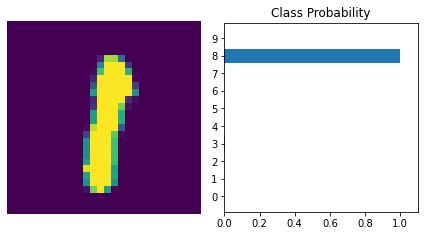

In [7]:
# Now let's start training the network
# Regular training, on clean data only
model = utils.train_model(model, X_train, X_test, y_train, y_test, epochs=5)

### Input Space (Dimensionality Reduction) Transforms - optional

In [8]:
# SKLearn method for determining a "minimum" number of components to reduce the dataset to
n_comp = johnson_lindenstrauss_min_dim(X_train.shape[0], eps=.99)

# Control (no transform): Wall time: 2min 53s, clean: 0.9733, adv: 0.8829
#transformer = None

# GaussianRandomProjection(n_components=374): Wall time: 1min 47s, clean: 0.9737, adv: 0.8892
# 2nd run: Wall time: 1min 52s, clean: 0.9727, adv: 0.911
#transformer = random_projection.GaussianRandomProjection(n_components=n_comp)

# SparseRandomProjection(n_components=374): Wall time: 1min 46s, clean: 0.9744, adv: 0.9247
# 2nd run: Wall time: 1min 47s, clean: 0.9706, adv: 0.8998
#transformer = random_projection.SparseRandomProjection(n_components=n_comp)

# PCA(n_components=374): Wall time: 1min 53s, clean: 0.9783, adv: 0.9137
# 2nd run: Wall time: 1min 32s, clean: 0.9757, adv: 0.9028
transformer = PCA(n_components=n_comp)

# FeatureAgglomeration(n_clusters=10):  Wall time: 46.2 s, clean: 0.8512, adv: 0.782
#transformer = cluster.FeatureAgglomeration(n_clusters=10)

### Fitting the clustering classifier on clean data

In [9]:
classifier = Classifier(model, transformer)

classifier.fit(X_train, y_train)

## Evaluation

### Scoring classifiers on clean data

In [10]:
print("Baseline classifier on clean test data: ")
utils.eval_model(baseline_model, X_test, y_test)

print("\nCluster Classifier Accuracy on clean test data: %.3f" % (classifier.score(X_test, y_test)))
print("Percentage of input data flagged as suspicious by detector: %.3f" % (classifier.proportion_flagged * 100))

Baseline classifier on clean test data: 
Model Accuracy = 0.9911

Cluster Classifier Accuracy on clean test data: 0.980
Percentage of input data flagged as suspicious by detector: 2.410


## Evaluating on adversarial data

In [11]:
test_eps = [2e-2, 4e-2, 8e-2, 1.6e-1, 3.2e-1]

for eps in test_eps:
    adv_test_data = utils.add_adversarial_noise(attacked_model, test_dataloader, eps=eps)
    test_data = np.concatenate((X_test, adv_test_data), axis=0)
    
    print("\nCurrent epsilon: %.2f\n" % (eps))
    
    # Base model accuracy on adversarial data
#     print("Underlying cnn of clustering classifier accuracy on adversarial data: ")
#     utils.eval_model(model, adv_test_data, y_test)
    
    # Testing both classifiers on adversarial data only
    print("Adversarial data only:\n")
    print("Baseline classifier: ")
    utils.eval_model(baseline_model, adv_test_data, y_test)

    print("\nCluster classifier: %.3f" % (classifier.score(adv_test_data, y_test)))
    print("Percentage of input data flagged as suspicious by detector: %.3f" % (classifier.proportion_flagged * 100))
    
    print("\nClean and adversarial data:\n")
    # Testing both classifiers on both clean and adversarial data 1:1 ratio
    print("Baseline classifier: ")
    utils.eval_model(baseline_model, test_data, test_labels)

    print("\nCluster classifier: %.3f" % (classifier.score(test_data, test_labels)))
    print("Percentage of input data flagged as suspicious by detector: %.3f" % (classifier.proportion_flagged * 100))


Current epsilon: 0.02

Adversarial data only:

Baseline classifier: 
Model Accuracy = 0.9918

Cluster classifier: 0.975
Percentage of input data flagged as suspicious by detector: 3.390

Clean and adversarial data:

Baseline classifier: 
Model Accuracy = 0.99145

Cluster classifier: 0.977
Percentage of input data flagged as suspicious by detector: 2.900

Current epsilon: 0.04

Adversarial data only:

Baseline classifier: 
Model Accuracy = 0.9911

Cluster classifier: 0.970
Percentage of input data flagged as suspicious by detector: 5.750

Clean and adversarial data:

Baseline classifier: 
Model Accuracy = 0.9911

Cluster classifier: 0.975
Percentage of input data flagged as suspicious by detector: 4.080

Current epsilon: 0.08

Adversarial data only:

Baseline classifier: 
Model Accuracy = 0.9876

Cluster classifier: 0.954
Percentage of input data flagged as suspicious by detector: 19.030

Clean and adversarial data:

Baseline classifier: 
Model Accuracy = 0.98935

Cluster classifier: 0